### Introduction
In  this notebook we will develop a model to predict the grades of students for Math and Portuguese. 
- Very small data size, which leads to the following challenges
    - Provide a model that generaizes well on new, unobserved data. We will use heavy regularization techniques to control overfitting
    - Estimate reliable model performance with a small confidence interval. We will use bootstrapping

### Imports

In [1]:
import pandas as pd # for data manipulation
import numpy as np # also for data manipulation
import xgboost as xgb # the model that we will run

from sklearn.preprocessing import LabelEncoder # for categorical variables
from sklearn.model_selection import train_test_split # to split data

import matplotlib.pyplot as plt # fr plotting
import plotly.plotly as py # for plotting
import seaborn as sns # for density plots

### Helper functions

In [2]:
# Wrapper function to compute rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    '''
    Computes rmse bertween to arrays
    :param y_true: actual values 
    :param y_pred: predictions
    :return: root mean squared error
    '''
    return sqrt(mean_squared_error(y_true, y_pred))

# Re-using a function from my github: 
# https://github.com/gonzalofrancoceballos/deep_learning_structured_data/blob/master/src/utils.py
def train_dev_test_split(data, train_size=0.9, random_state=1):
    '''
    Given a list of np.arrays, sample them in train, dev and test, where dev 
    and test sizes will be the same
    
    :param data: list of np.arrays
    :param train_size: proportion of train data. Dev and test sizes will be 
    (1-train_size)/2
    :param random_state: seed
    '''
    I = np.arange(0, data[0].shape[0])
    I_train, I_dev_test = train_test_split(I, test_size=1-train_size, random_state=random_state)
    I_dev, I_test = train_test_split(I_dev_test, test_size=0.5, random_state=random_state)
    
    train_split = []
    dev_split = []
    test_split= []

    for elem in data:
        train_split.append(elem[I_train])
        dev_split.append(elem[I_dev])
        test_split.append(elem[I_test])
    
    return  train_split, dev_split, test_split


def print_distribution(scores, bins=250):
    '''
    Prints the distribution of a continous variable
    '''
    sns.set(color_codes=True)
    print("avg_value: {}\nmax_value: {}\nmin_value: {}".format(np.mean(scores), 
                                                               np.max(scores),
                                                               np.min(scores)))
    sns.distplot(scores,bins=bins)
    plt.show()

### Reading data

In [3]:
# Reading data for both subjects
dataset_math = pd.read_csv("./../data/student-mat.csv")
dataset_port = pd.read_csv("./../data/student-por.csv")

# We create a synthetic variable to let the model see what population the record belongs to
# This will only really be used in the simgle model. But we do it here for simplicity
dataset_math["fl_math"] = 1
dataset_port["fl_math"] = 0

### Encoding categorical variables
Two simplifications here
- We should first split into train, dev and test and only fit the encoder on train set. This way, there might be un-observed values when evaluating the model, which is what happens in real life. Since this data comes from a survey, we will assume that values are fixed to the range we see here
- We are going to label-encode all categories, instead of using one-hot-encoding. As seen in exploratory analysis, 13 out of 16 variables are binary, so this simplification will only have an impact on the remaining 3. Only if the model identifies these variables as important will we consider one-hot-encoding them. Boosting trees like XGB or LightGBM generally have no problem dealing with non-ordinal label-encoded categories when they are small

In [4]:
# Encoding math students
char_cols_math = dataset_math.select_dtypes(include=[np.dtype('O')]).columns
encoder_dict_math = {}
for char_col in char_cols_math:
    encoder_dict_math[char_col] = LabelEncoder()
    encoder_dict_math[char_col].fit(dataset_math[char_col])
    dataset_math[char_col] =  encoder_dict_math[char_col].transform(dataset_math[char_col])
    
# Encoding portuguese students
char_cols_port = dataset_port.select_dtypes(include=[np.dtype('O')]).columns
encoder_dict_port = {}
for char_col in char_cols_port:
    encoder_dict_port[char_col] = LabelEncoder()
    encoder_dict_port[char_col].fit(dataset_port[char_col])
    dataset_port[char_col] =  encoder_dict_port[char_col].transform(dataset_port[char_col])

### Train - dev - test split
- Train: what the model sees (data used to train the model)
- Dev: what we see (data used to know when the model is starting to overfit)
- Test: what nobody sees (data used to test the performance of the model)

In [5]:
# Splitting both populations into train-dev-test
train_size = 0.7
I_math = np.arange(dataset_math.shape[0])
I_port = np.arange(dataset_port.shape[0])
[I_math_train, I_port_train] , [I_math_dev, I_port_dev], [I_math_test, I_port_test] = train_dev_test_split(data=[I_math, I_port],
                                                                                                           train_size=train_size)
dataset_math_train = dataset_math.iloc[I_math_train,:]
dataset_math_dev = dataset_math.iloc[I_math_dev,:]
dataset_math_test = dataset_math.iloc[I_math_test,:]
dataset_port_train = dataset_port.iloc[I_port_train,:]
dataset_port_dev = dataset_port.iloc[I_port_dev,:]
dataset_port_test = dataset_port.iloc[I_port_test,:]

### Training  math students
We will train a first model for math students to have preliminary results that can be our baseline for the rest of the exercise

In [6]:
# Identifying feature and target columns
target_cols = ["G1", "G2" , "G3"]
train_cols = dataset_math.columns
train_cols = list(filter(lambda x : x not in target_cols, train_cols))

In [7]:
# Creating feature matrices
X_train = dataset_math_train[train_cols].as_matrix()
X_dev = dataset_math_dev[train_cols].as_matrix()
X_test = dataset_math_test[train_cols].as_matrix()

In [8]:
# Let's crete a simple wrapper function function to train several models with different tree_depths 
def train_simple_model(X_train, X_dev,
                       dataset_train, dataset_dev,
                       target_cols, tree_depth, verbose_eval=1):
    models = {}
    # Training for each target
    for target_col in target_cols:
        print("Training on target: {}".format(target_col))
        y_train = dataset_train[target_col].values
        y_dev = dataset_dev[target_col].values
        
        d_train = xgb.DMatrix(X_train, label=y_train)
        d_dev = xgb.DMatrix(X_dev, label=y_dev)
        params = {
            'max_depth': tree_depth, 
            'eta': 0.1, 
            'silent' : 1, 
            'objective': 'reg:linear'} 
        n_rounds = 10000  # the number of training iterations

        watch_list  = [(d_train,'train'), (d_dev,'dev')]
        model = xgb.train(params, d_train, n_rounds, watch_list, verbose_eval=verbose_eval, early_stopping_rounds=10)

        models[target_col] = {"model":model}
    return models

In [9]:
# Training models with different depths
math_models = {}
for tree_depth in range(1,7):
    print("Training moel for tree depth = {}".format(tree_depth))
    models_i = train_simple_model(X_train, X_dev,
                       dataset_math_train, dataset_math_dev, target_cols, 
                       tree_depth)
    math_models[tree_depth] = models_i

Training moel for tree depth = 1
Training on target: G1
[0]	train-rmse:9.99674	dev-rmse:9.92056
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[1]	train-rmse:9.11162	dev-rmse:9.04011
[2]	train-rmse:8.32403	dev-rmse:8.25585
[3]	train-rmse:7.62569	dev-rmse:7.56077
[4]	train-rmse:7.00777	dev-rmse:6.945
[5]	train-rmse:6.46218	dev-rmse:6.40971
[6]	train-rmse:5.98262	dev-rmse:5.93177
[7]	train-rmse:5.56249	dev-rmse:5.52
[8]	train-rmse:5.19582	dev-rmse:5.15363
[9]	train-rmse:4.87738	dev-rmse:4.849
[10]	train-rmse:4.60177	dev-rmse:4.57957
[11]	train-rmse:4.3643	dev-rmse:4.34055
[12]	train-rmse:4.16052	dev-rmse:4.14036
[13]	train-rmse:3.98662	dev-rmse:3.96538
[14]	train-rmse:3.83835	dev-rmse:3.82127
[15]	train-rmse:3.71259	dev-rmse:3.70039
[16]	train-rmse:3.60624	dev-rmse:3.5917
[17]	train-rmse:3.51641	dev-rmse:3.5122
[18]	train-rmse:3.44089	dev-rmse:3.43531
[19]	train-rmse:3.3774	dev-rmse:3.37671
[20]

[58]	train-rmse:3.41182	dev-rmse:2.82225
[59]	train-rmse:3.40802	dev-rmse:2.82516
[60]	train-rmse:3.4043	dev-rmse:2.83109
[61]	train-rmse:3.40067	dev-rmse:2.82742
Stopping. Best iteration:
[51]	train-rmse:3.43986	dev-rmse:2.81693

Training on target: G3
[0]	train-rmse:10.1241	dev-rmse:9.94756
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[1]	train-rmse:9.32046	dev-rmse:9.11981
[2]	train-rmse:8.61381	dev-rmse:8.38599
[3]	train-rmse:7.99495	dev-rmse:7.73726
[4]	train-rmse:7.45228	dev-rmse:7.12042
[5]	train-rmse:6.98046	dev-rmse:6.61649
[6]	train-rmse:6.57009	dev-rmse:6.1362
[7]	train-rmse:6.21601	dev-rmse:5.76586
[8]	train-rmse:5.91128	dev-rmse:5.43003
[9]	train-rmse:5.649	dev-rmse:5.10697
[10]	train-rmse:5.42524	dev-rmse:4.86631
[11]	train-rmse:5.23517	dev-rmse:4.6667
[12]	train-rmse:5.07327	dev-rmse:4.46856
[13]	train-rmse:4.93568	dev-rmse:4.2862
[14]	train-rmse:4.82052	dev-rmse:4.16434
[15]	

[60]	train-rmse:2.84261	dev-rmse:2.77281
[61]	train-rmse:2.83815	dev-rmse:2.77734
[62]	train-rmse:2.82948	dev-rmse:2.76268
[63]	train-rmse:2.81282	dev-rmse:2.76277
[64]	train-rmse:2.80539	dev-rmse:2.77408
[65]	train-rmse:2.79784	dev-rmse:2.7755
[66]	train-rmse:2.7868	dev-rmse:2.77756
[67]	train-rmse:2.7786	dev-rmse:2.77601
[68]	train-rmse:2.7718	dev-rmse:2.78041
[69]	train-rmse:2.768	dev-rmse:2.7833
[70]	train-rmse:2.76065	dev-rmse:2.77662
[71]	train-rmse:2.74656	dev-rmse:2.77832
[72]	train-rmse:2.7403	dev-rmse:2.79017
Stopping. Best iteration:
[62]	train-rmse:2.82948	dev-rmse:2.76268

Training on target: G3
[0]	train-rmse:10.0954	dev-rmse:9.90009
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[1]	train-rmse:9.26253	dev-rmse:9.05099
[2]	train-rmse:8.52567	dev-rmse:8.2968
[3]	train-rmse:7.87627	dev-rmse:7.6151
[4]	train-rmse:7.30583	dev-rmse:7.01221
[5]	train-rmse:6.80637	dev-rmse:6.49391
[6]	t

[47]	train-rmse:2.38743	dev-rmse:2.7587
[48]	train-rmse:2.37093	dev-rmse:2.75921
[49]	train-rmse:2.34512	dev-rmse:2.77733
[50]	train-rmse:2.33555	dev-rmse:2.78229
[51]	train-rmse:2.31358	dev-rmse:2.79353
[52]	train-rmse:2.29597	dev-rmse:2.79357
[53]	train-rmse:2.28593	dev-rmse:2.79459
[54]	train-rmse:2.26855	dev-rmse:2.79872
[55]	train-rmse:2.24667	dev-rmse:2.78029
Stopping. Best iteration:
[45]	train-rmse:2.40459	dev-rmse:2.74661

Training on target: G3
[0]	train-rmse:10.0873	dev-rmse:9.90161
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[1]	train-rmse:9.24257	dev-rmse:9.07085
[2]	train-rmse:8.49538	dev-rmse:8.30932
[3]	train-rmse:7.829	dev-rmse:7.61606
[4]	train-rmse:7.23907	dev-rmse:7.03147
[5]	train-rmse:6.72458	dev-rmse:6.51402
[6]	train-rmse:6.26846	dev-rmse:6.07048
[7]	train-rmse:5.87192	dev-rmse:5.67929
[8]	train-rmse:5.51861	dev-rmse:5.30307
[9]	train-rmse:5.21115	dev-rmse:4.99658
[1

[20]	train-rmse:3.06399	dev-rmse:3.64087
[21]	train-rmse:2.97123	dev-rmse:3.59033
[22]	train-rmse:2.89222	dev-rmse:3.57028
[23]	train-rmse:2.82379	dev-rmse:3.55343
[24]	train-rmse:2.7507	dev-rmse:3.55697
[25]	train-rmse:2.70293	dev-rmse:3.53077
[26]	train-rmse:2.63852	dev-rmse:3.51183
[27]	train-rmse:2.57332	dev-rmse:3.49279
[28]	train-rmse:2.51865	dev-rmse:3.48383
[29]	train-rmse:2.46034	dev-rmse:3.47977
[30]	train-rmse:2.41396	dev-rmse:3.46887
[31]	train-rmse:2.36292	dev-rmse:3.47827
[32]	train-rmse:2.33477	dev-rmse:3.47171
[33]	train-rmse:2.30284	dev-rmse:3.4662
[34]	train-rmse:2.25897	dev-rmse:3.44895
[35]	train-rmse:2.24555	dev-rmse:3.44422
[36]	train-rmse:2.20336	dev-rmse:3.45064
[37]	train-rmse:2.19246	dev-rmse:3.4537
[38]	train-rmse:2.14917	dev-rmse:3.44782
[39]	train-rmse:2.11754	dev-rmse:3.4357
[40]	train-rmse:2.09669	dev-rmse:3.43628
[41]	train-rmse:2.07882	dev-rmse:3.43317
[42]	train-rmse:2.04225	dev-rmse:3.43655
[43]	train-rmse:2.00883	dev-rmse:3.4495
[44]	train-rmse:1.993

Training moel for tree depth = 6
Training on target: G1
[0]	train-rmse:9.9917	dev-rmse:9.9379
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[1]	train-rmse:9.09678	dev-rmse:9.10025
[2]	train-rmse:8.29624	dev-rmse:8.32753
[3]	train-rmse:7.57984	dev-rmse:7.63962
[4]	train-rmse:6.93283	dev-rmse:7.03893
[5]	train-rmse:6.35926	dev-rmse:6.51782
[6]	train-rmse:5.83844	dev-rmse:6.06464
[7]	train-rmse:5.37036	dev-rmse:5.67106
[8]	train-rmse:4.9527	dev-rmse:5.30515
[9]	train-rmse:4.57666	dev-rmse:5.02769
[10]	train-rmse:4.23946	dev-rmse:4.77808
[11]	train-rmse:3.92816	dev-rmse:4.52621
[12]	train-rmse:3.64943	dev-rmse:4.34625
[13]	train-rmse:3.39682	dev-rmse:4.2025
[14]	train-rmse:3.17229	dev-rmse:4.08324
[15]	train-rmse:2.96375	dev-rmse:3.95063
[16]	train-rmse:2.77577	dev-rmse:3.83159
[17]	train-rmse:2.61107	dev-rmse:3.74005
[18]	train-rmse:2.45159	dev-rmse:3.65161
[19]	train-rmse:2.31015	dev-rmse:3.598

### Analyzing results
- We see that best performance is achieved with a depth of 2
- Looking at train logs, we see that sometimes dev results are bigger than train results. This is because dev set is so small that it is not statistically representative, and we can have a sample where the model does better than normal. We will solve this issue later by combining models and using bootstrapping

In [10]:
# Quick code to make predictions on test data
d_test = xgb.DMatrix(X_test)
for math_models_key in math_models:
    models = math_models[math_models_key]
    for key in models:
        model_i = models[key]["model"]
        y_pred = model_i.predict(d_test)
        y_true = dataset_math_test[key].values    

        models[key]["scores"] = {}
        models[key]["scores"]["dev"] = model_i.best_score
        models[key]["scores"]["test"] = rmse(y_true, y_pred)
        
    print("Depth = {}".format(math_models_key))
    print("G1 -- dev: {} test: {}".format(models["G1"]["scores"]["dev"], models["G1"]["scores"]["test"]))
    print("G2 -- dev: {} test: {}".format(models["G2"]["scores"]["dev"], models["G2"]["scores"]["test"]))
    print("G3 -- dev: {} test: {}".format(models["G3"]["scores"]["dev"], models["G3"]["scores"]["test"]))

Depth = 1
G1 -- dev: 2.969583 test: 2.582023367622659
G2 -- dev: 2.816927 test: 3.4301005827353
G3 -- dev: 3.433065 test: 3.975962450313764
Depth = 2
G1 -- dev: 2.956197 test: 2.5784438419492837
G2 -- dev: 2.762676 test: 3.5023817133033166
G3 -- dev: 3.226367 test: 4.055258256928855
Depth = 3
G1 -- dev: 2.915518 test: 2.704117851250522
G2 -- dev: 2.746612 test: 3.5213160445418414
G3 -- dev: 3.304404 test: 4.179323453946686
Depth = 4
G1 -- dev: 3.096937 test: 2.8207241207100653
G2 -- dev: 2.799159 test: 3.7812904313035274
G3 -- dev: 3.433168 test: 4.220673849948409
Depth = 5
G1 -- dev: 3.087394 test: 2.8678232010770968
G2 -- dev: 3.035813 test: 3.7339598486125736
G3 -- dev: 3.540736 test: 4.31288022399359
Depth = 6
G1 -- dev: 3.217711 test: 2.784181393014623
G2 -- dev: 2.855735 test: 3.6267103871899518
G3 -- dev: 3.669122 test: 4.456053467167126


### Plotting preliminary results
We can see that, overall, results are fairly good for the small amount of data

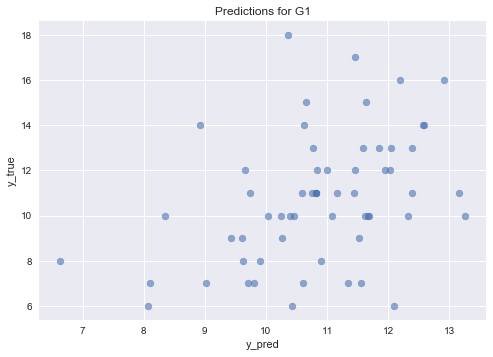

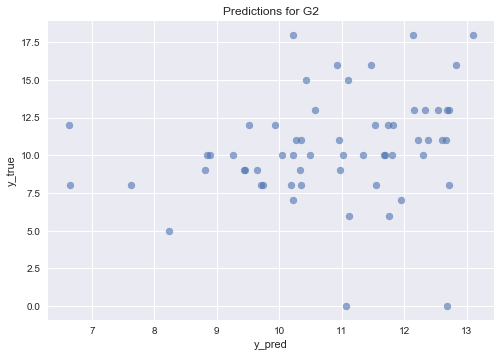

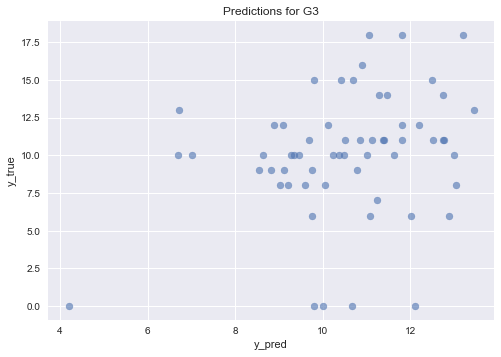

In [11]:
best_models = 2
models = math_models[2]

for key in models:
    model_i = models[key]["model"]
    y_pred = model_i.predict(d_test)
    y_true = dataset_math_test[key].values    
    
    plt.scatter(y_pred, y_true, alpha=0.6)
    plt.title('Predictions for {}'.format(key))
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    plt.show()

### Training with both populations together
We will now train a model with both populations and evaluate its performance

In [12]:
# COncatenating both dataset
dataset_all = pd.concat([dataset_math, dataset_port[dataset_math.columns.tolist()]])

In [13]:
# Splitting both populations into train-dev-test
train_size = 0.7
I_all = np.arange(dataset_all.shape[0])
[I_all_train] , [I_all_dev], [I_all_test] = train_dev_test_split(data=[I_all],
                                                                                                           train_size=train_size)
dataset_all_train = dataset_all.iloc[I_all_train,:]
dataset_all_dev = dataset_all.iloc[I_all_dev,:]
dataset_all_test = dataset_all.iloc[I_all_test,:]

# Creating feature matrices
X_train = dataset_all_train[train_cols].as_matrix()
X_dev = dataset_all_dev[train_cols].as_matrix()
X_test = dataset_all_test[train_cols].as_matrix()

In [14]:
# Training models with different depths
all_models = {}
for tree_depth in range(1,7):
    print("Training moel for tree depth = {}".format(tree_depth))
    models_i = train_simple_model(X_train, X_dev,
                       dataset_all_train, dataset_all_dev, target_cols, 
                       tree_depth,    verbose_eval=10)
    all_models[tree_depth] = models_i

Training moel for tree depth = 1
Training on target: G1
[0]	train-rmse:10.0771	dev-rmse:10.0426
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[10]	train-rmse:4.36108	dev-rmse:4.29264
[20]	train-rmse:2.94442	dev-rmse:2.79817
[30]	train-rmse:2.68265	dev-rmse:2.51476
[40]	train-rmse:2.6188	dev-rmse:2.46336
[50]	train-rmse:2.58693	dev-rmse:2.44201
[60]	train-rmse:2.56343	dev-rmse:2.4258
[70]	train-rmse:2.54389	dev-rmse:2.42471
[80]	train-rmse:2.52741	dev-rmse:2.41768
[90]	train-rmse:2.51289	dev-rmse:2.41628
[100]	train-rmse:2.50051	dev-rmse:2.40882
[110]	train-rmse:2.48962	dev-rmse:2.41201
Stopping. Best iteration:
[100]	train-rmse:2.50051	dev-rmse:2.40882

Training on target: G2
[0]	train-rmse:10.1734	dev-rmse:10.1559
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[10]	train-rmse:4.52538	dev-rmse:4.6397

Stopping. Best iteration:
[56]	train-rmse:1.66358	dev-rmse:3.37359

Training moel for tree depth = 6
Training on target: G1
[0]	train-rmse:10.0739	dev-rmse:10.048
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[10]	train-rmse:4.15325	dev-rmse:4.32704
[20]	train-rmse:2.27115	dev-rmse:2.79775
[30]	train-rmse:1.63367	dev-rmse:2.48734
[40]	train-rmse:1.2848	dev-rmse:2.43254
Stopping. Best iteration:
[39]	train-rmse:1.30497	dev-rmse:2.42961

Training on target: G2
[0]	train-rmse:10.1649	dev-rmse:10.1601
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[10]	train-rmse:4.19817	dev-rmse:4.73719
[20]	train-rmse:2.27307	dev-rmse:3.3738
[30]	train-rmse:1.60441	dev-rmse:3.15012
[40]	train-rmse:1.31195	dev-rmse:3.12725
Stopping. Best iteration:
[35]	train-rmse:1.43148	dev-rmse:3.11745

Training on target: G3
[0]	tra

### Analizing results for single model on entire population
Results are not so good. But we are now testing on a different population. In order to make a fair comparison, we need to evaluate the model on the same population we used before, that is, math students 

In [15]:
# Quick code to make predictions on test data
d_test = xgb.DMatrix(X_test)
for all_models_key in all_models:
    models = all_models[all_models_key]
    for key in models:
        model_i = models[key]["model"]
        y_pred = model_i.predict(d_test)
        y_true = dataset_all_test[key].values    

        models[key]["scores"] = {}
        models[key]["scores"]["dev"] = model_i.best_score
        models[key]["scores"]["test"] = rmse(y_true, y_pred)
        
    print("Depth = {}".format(all_models_key))
    print("G1 -- dev: {} test: {}".format(models["G1"]["scores"]["dev"], models["G1"]["scores"]["test"]))
    print("G2 -- dev: {} test: {}".format(models["G2"]["scores"]["dev"], models["G2"]["scores"]["test"]))
    print("G3 -- dev: {} test: {}".format(models["G3"]["scores"]["dev"], models["G3"]["scores"]["test"]))

Depth = 1
G1 -- dev: 2.408823 test: 2.8255298309438346
G2 -- dev: 3.078689 test: 2.918761721218849
G3 -- dev: 3.421877 test: 3.1555254470282237
Depth = 2
G1 -- dev: 2.417144 test: 2.741835198601659
G2 -- dev: 3.015695 test: 2.886220705780817
G3 -- dev: 3.226592 test: 3.1128355833329455
Depth = 3
G1 -- dev: 2.391866 test: 2.65304942262198
G2 -- dev: 3.086923 test: 2.854032441946672
G3 -- dev: 3.208953 test: 3.0411500513381733
Depth = 4
G1 -- dev: 2.364667 test: 2.561179075520198
G2 -- dev: 3.091264 test: 2.7991842102392486
G3 -- dev: 3.367014 test: 3.0889815693966023
Depth = 5
G1 -- dev: 2.340649 test: 2.583762566258891
G2 -- dev: 3.036435 test: 2.7415219906802504
G3 -- dev: 3.373594 test: 3.1344880374648794
Depth = 6
G1 -- dev: 2.42961 test: 2.592031063742886
G2 -- dev: 3.117447 test: 2.984184531970706
G3 -- dev: 3.493007 test: 3.195481356625949


### Analizing results for single model on Math students
- Now results are better
- We can use deeper trees without overfitting. This is because now we have more data
- Still, model performance might not be reliable due to small samples 

In [16]:
# This time, we only used math students for test
X_test = dataset_math_test[train_cols].as_matrix()
# Quick code to make predictions on test data
d_test = xgb.DMatrix(X_test)
for all_models_key in all_models:
    models = all_models[all_models_key]
    for key in models:
        model_i = models[key]["model"]
        y_pred = model_i.predict(d_test)
        y_true = dataset_math_test[key].values    

        models[key]["scores"] = {}
        models[key]["scores"]["dev"] = model_i.best_score
        models[key]["scores"]["test"] = rmse(y_true, y_pred)
        
    print("Depth = {}".format(all_models_key))
    print("G1 -- dev: {} test: {}".format(models["G1"]["scores"]["dev"], models["G1"]["scores"]["test"]))
    print("G2 -- dev: {} test: {}".format(models["G2"]["scores"]["dev"], models["G2"]["scores"]["test"]))
    print("G3 -- dev: {} test: {}".format(models["G3"]["scores"]["dev"], models["G3"]["scores"]["test"]))

Depth = 1
G1 -- dev: 2.408823 test: 2.6337859612217054
G2 -- dev: 3.078689 test: 3.401941452861488
G3 -- dev: 3.421877 test: 4.028552491311994
Depth = 2
G1 -- dev: 2.417144 test: 2.565346990755154
G2 -- dev: 3.015695 test: 3.2687758150734405
G3 -- dev: 3.226592 test: 3.7447611477561495
Depth = 3
G1 -- dev: 2.391866 test: 2.481242735885582
G2 -- dev: 3.086923 test: 3.1567824961775237
G3 -- dev: 3.208953 test: 3.493437350901739
Depth = 4
G1 -- dev: 2.364667 test: 2.311138685372136
G2 -- dev: 3.091264 test: 3.0601873187234467
G3 -- dev: 3.367014 test: 3.227972585943923
Depth = 5
G1 -- dev: 2.340649 test: 2.1422911954752184
G2 -- dev: 3.036435 test: 2.6894532066145
G3 -- dev: 3.373594 test: 3.0323402952247713
Depth = 6
G1 -- dev: 2.42961 test: 1.8963030737593243
G2 -- dev: 3.117447 test: 2.822148041846475
G3 -- dev: 3.493007 test: 2.8347283785549635


### Feature importance
- Number of failed classes in the past is the most important variable, which makes sense. If a student has failed serveal subjects before, he or she is more likely to fail again
- Very interesting that mother's education is one of the most important variables
- We see that fl_math is more important for later semesters. That means that at the begining of the year both populations behave more similarly, and the model does not need to differenciate between them so much to give a grade in Portuguese or Math
- Important to mention weekend and workday alcohol consunption, which are the original focus of this study when this dataset was released. They turned out to be fairly important

In [17]:
def get_feature_importance(model, train_cols):
    feature_importance = model.get_score(importance_type="gain")
    I_features = list(map(lambda x: int(x[1:]), feature_importance.keys()))
    gains = feature_importance.values()
    gains = np.array(list(gains))/sum(gains)
    imp_feat_names = []
    for i in I_features:
        imp_feat_names.append(train_cols[i])

    feature_importance = pd.DataFrame({"feature" :imp_feat_names, "gain":gains})
    feature_importance.sort_values("gain",ascending=False, inplace=False)
    
    return feature_importance

In [18]:
feature_importance_G1 = get_feature_importance(all_models[2]["G1"]["model"], train_cols)
feature_importance_G2 = get_feature_importance(all_models[2]["G2"]["model"], train_cols)
feature_importance_G3 = get_feature_importance(all_models[2]["G3"]["model"], train_cols)

In [19]:
print("Feature importance for G1:")
feature_importance_G1

Feature importance for G1:


,feature,gain
0,failures,0.175091
1,higher,0.068721
2,schoolsup,0.042442
3,Medu,0.046985
4,school,0.036676
5,absences,0.027237
6,studytime,0.057311
7,Walc,0.025941
8,Fjob,0.045709
9,Mjob,0.046623


In [20]:
print("Feature importance for G2:")
feature_importance_G2

Feature importance for G2:


,feature,gain
0,failures,0.227420
1,higher,0.044762
2,absences,0.042141
3,fl_math,0.042315
4,Medu,0.047716
5,schoolsup,0.032225
6,studytime,0.039198
7,Dalc,0.046014
8,famrel,0.019586
9,address,0.033697


In [21]:
print("Feature importance for G3:")
feature_importance_G3

Feature importance for G3:


,feature,gain
0,failures,0.222098
1,fl_math,0.060282
2,absences,0.091336
3,higher,0.047015
4,Medu,0.043941
5,schoolsup,0.045536
6,studytime,0.029611
7,Dalc,0.044703
8,address,0.028939
9,goout,0.020953


### Bootstrapping for reliable model evaluation
Finally. We will use bootstrapping to have a more reliable metric to report. 
- In bootstrapping, we sample the population several times with replacement, and compute a statistical value in each time. This results in a set of values that, if the sampling is big enough, would lead to a more reliable value than if we just computed a single value.
- In this case, the value we will be computing is the rmse. For each iteration, we will do a different train-dev-test split and calculate the resulting rmse on test set. Then we will report the average rmse of all samples as the final, reliable performance of the model

In [22]:
# Wrapper function for bootstrapping
# This simply implements the logic explained above
def bootstrapping(N=10, tree_depth=2, verbose_eval=1):
    bootstrapping_models = {}
    for seed_i in range(N):
        print("Sampling #{}".format(seed_i))
        # TRAIN-DEV-TEST SPLIT
        train_size = 0.7
        I_all = np.arange(dataset_all.shape[0])
        [I_all_train] , [I_all_dev], [I_all_test] = train_dev_test_split(data=[I_all], random_state=seed_i, train_size=train_size)
        dataset_all_train = dataset_all.iloc[I_all_train,:]
        dataset_all_dev = dataset_all.iloc[I_all_dev,:]
        dataset_all_test = dataset_all.iloc[I_all_test,:]
        # Creating feature matrices
        X_train = dataset_all_train[train_cols].as_matrix()
        X_dev = dataset_all_dev[train_cols].as_matrix()
        X_test = dataset_all_test[train_cols].as_matrix()

        # MODEL TRAIN
        models = train_simple_model(X_train, X_dev,
                                      dataset_all_train, dataset_all_dev,  
                                      target_cols, tree_depth,verbose_eval=verbose_eval)


        bootstrapping_models[seed_i] = models
        # MODEL PERFORMANCE
        d_test = xgb.DMatrix(X_test)
        for key in models:
            model_i = models[key]["model"]
            y_pred = model_i.predict(d_test)
            y_true = dataset_all_test[key].values    

            bootstrapping_models[seed_i][key]["scores"] = {}
            bootstrapping_models[seed_i][key]["scores"]["dev"] = model_i.best_score
            bootstrapping_models[seed_i][key]["scores"]["test"] = rmse(y_true, y_pred)
            
            bootstrapping_models[seed_i][key]["y_pred"] = y_pred
    return bootstrapping_models

In [23]:
N_bootstraps = 100
bootstrap_results = bootstrapping(N=N_bootstraps, tree_depth=2, verbose_eval=25)

Sampling #0
Training on target: G1
[0]	train-rmse:10.1325	dev-rmse:9.82496
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.64417	dev-rmse:2.68035
[50]	train-rmse:2.42828	dev-rmse:2.60764
[75]	train-rmse:2.35041	dev-rmse:2.58212
[100]	train-rmse:2.28314	dev-rmse:2.56272
Stopping. Best iteration:
[109]	train-rmse:2.26409	dev-rmse:2.55199

Training on target: G2
[0]	train-rmse:10.2297	dev-rmse:10.1139
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.01753	dev-rmse:2.68017
[50]	train-rmse:2.79499	dev-rmse:2.50907
[75]	train-rmse:2.71007	dev-rmse:2.44604
[100]	train-rmse:2.64476	dev-rmse:2.42215
[125]	train-rmse:2.59132	dev-rmse:2.40571
[150]	train-rmse:2.54378	dev-rmse:2.38405
[175]	train-rmse:2.50033	dev-rmse:2.3539
[200]	train-rmse:2.45247	dev-rmse:2.33783
[225]	train-rm

Training on target: G3
[0]	train-rmse:10.4765	dev-rmse:10.2811
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.23598	dev-rmse:3.47024
[50]	train-rmse:2.99239	dev-rmse:3.39671
[75]	train-rmse:2.88858	dev-rmse:3.34098
Stopping. Best iteration:
[75]	train-rmse:2.88858	dev-rmse:3.34098

Sampling #7
Training on target: G1
[0]	train-rmse:10.1147	dev-rmse:9.85947
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.59915	dev-rmse:2.73114
[50]	train-rmse:2.37316	dev-rmse:2.63383
[75]	train-rmse:2.29346	dev-rmse:2.59203
Stopping. Best iteration:
[85]	train-rmse:2.2673	dev-rmse:2.58476

Training on target: G2
[0]	train-rmse:10.2212	dev-rmse:10.1265
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rou

Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.85415	dev-rmse:3.14903
[50]	train-rmse:2.63194	dev-rmse:2.9029
[75]	train-rmse:2.5412	dev-rmse:2.8861
[100]	train-rmse:2.47685	dev-rmse:2.87081
Stopping. Best iteration:
[90]	train-rmse:2.5009	dev-rmse:2.86958

Training on target: G3
[0]	train-rmse:10.3206	dev-rmse:11.0185
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.17728	dev-rmse:3.77823
[50]	train-rmse:2.92066	dev-rmse:3.56894
Stopping. Best iteration:
[63]	train-rmse:2.86138	dev-rmse:3.54987

Sampling #14
Training on target: G1
[0]	train-rmse:10.0962	dev-rmse:10.1532
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.62763	dev-rmse:2.72317
[50]	train-rmse:2.

[25]	train-rmse:3.25794	dev-rmse:2.90316
[50]	train-rmse:2.99934	dev-rmse:2.73267
[75]	train-rmse:2.87976	dev-rmse:2.6991
[100]	train-rmse:2.79039	dev-rmse:2.6967
Stopping. Best iteration:
[91]	train-rmse:2.8202	dev-rmse:2.68713

Sampling #20
Training on target: G1
[0]	train-rmse:10.1036	dev-rmse:9.84034
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.59366	dev-rmse:2.5769
[50]	train-rmse:2.36695	dev-rmse:2.4254
[75]	train-rmse:2.2884	dev-rmse:2.39963
Stopping. Best iteration:
[73]	train-rmse:2.29236	dev-rmse:2.39814

Training on target: G2
[0]	train-rmse:10.26	dev-rmse:9.81051
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.93581	dev-rmse:2.79197
[50]	train-rmse:2.70929	dev-rmse:2.6809
[75]	train-rmse:2.61383	dev-rmse:2.63515
[100]	train-rmse:2.55563	dev-rmse:2.6082


Training on target: G3
[0]	train-rmse:10.4576	dev-rmse:10.5709
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.20602	dev-rmse:3.49457
[50]	train-rmse:2.95449	dev-rmse:3.38048
Stopping. Best iteration:
[63]	train-rmse:2.89252	dev-rmse:3.37104

Sampling #27
Training on target: G1
[0]	train-rmse:10.0273	dev-rmse:10.1775
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.58628	dev-rmse:2.94898
[50]	train-rmse:2.36298	dev-rmse:2.78415
[75]	train-rmse:2.27789	dev-rmse:2.74671
[100]	train-rmse:2.21181	dev-rmse:2.71518
[125]	train-rmse:2.16144	dev-rmse:2.70741
[150]	train-rmse:2.11741	dev-rmse:2.70081
[175]	train-rmse:2.07815	dev-rmse:2.69384
[200]	train-rmse:2.04518	dev-rmse:2.68678
Stopping. Best iteration:
[197]	train-rmse:2.05021	dev-rmse:2.68252

Training on target: G2
[0]	

Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.9155	dev-rmse:2.90798
[50]	train-rmse:2.67844	dev-rmse:2.74631
[75]	train-rmse:2.59183	dev-rmse:2.71612
Stopping. Best iteration:
[68]	train-rmse:2.61391	dev-rmse:2.71402

Training on target: G3
[0]	train-rmse:10.4586	dev-rmse:10.6376
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.23632	dev-rmse:3.3761
[50]	train-rmse:2.99146	dev-rmse:3.26811
[75]	train-rmse:2.89397	dev-rmse:3.21827
[100]	train-rmse:2.81475	dev-rmse:3.19909
Stopping. Best iteration:
[108]	train-rmse:2.79777	dev-rmse:3.19023

Sampling #34
Training on target: G1
[0]	train-rmse:10.0825	dev-rmse:9.95665
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse

[0]	train-rmse:10.1213	dev-rmse:9.79233
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.61344	dev-rmse:2.59095
[50]	train-rmse:2.38918	dev-rmse:2.4818
[75]	train-rmse:2.31382	dev-rmse:2.4438
[100]	train-rmse:2.25853	dev-rmse:2.41179
[125]	train-rmse:2.21293	dev-rmse:2.38603
[150]	train-rmse:2.16568	dev-rmse:2.37378
[175]	train-rmse:2.12775	dev-rmse:2.35901
[200]	train-rmse:2.09512	dev-rmse:2.34293
[225]	train-rmse:2.0644	dev-rmse:2.32875
[250]	train-rmse:2.03508	dev-rmse:2.31335
[275]	train-rmse:2.00697	dev-rmse:2.29974
[300]	train-rmse:1.98168	dev-rmse:2.29014
Stopping. Best iteration:
[301]	train-rmse:1.98078	dev-rmse:2.28946

Training on target: G2
[0]	train-rmse:10.2218	dev-rmse:9.88489
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.82983	dev-rmse:3.19021
[50]	tr

Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.59588	dev-rmse:2.76744
[50]	train-rmse:2.37033	dev-rmse:2.58832
[75]	train-rmse:2.29126	dev-rmse:2.56352
[100]	train-rmse:2.22821	dev-rmse:2.54575
Stopping. Best iteration:
[98]	train-rmse:2.23283	dev-rmse:2.54556

Training on target: G2
[0]	train-rmse:10.1465	dev-rmse:10.2512
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.85407	dev-rmse:3.02321
[50]	train-rmse:2.61981	dev-rmse:2.87968
[75]	train-rmse:2.52544	dev-rmse:2.86375
[100]	train-rmse:2.46121	dev-rmse:2.83905
[125]	train-rmse:2.41013	dev-rmse:2.82213
[150]	train-rmse:2.36669	dev-rmse:2.81545
Stopping. Best iteration:
[141]	train-rmse:2.38053	dev-rmse:2.81256

Training on target: G3
[0]	train-rmse:10.4261	dev-rmse:10.5643
Multiple eval metrics have been passed: '

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.96347	dev-rmse:2.68702
[50]	train-rmse:2.74449	dev-rmse:2.52885
[75]	train-rmse:2.65448	dev-rmse:2.50993
Stopping. Best iteration:
[80]	train-rmse:2.64073	dev-rmse:2.49861

Training on target: G3
[0]	train-rmse:10.3583	dev-rmse:10.3392
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.36398	dev-rmse:3.13842
[50]	train-rmse:3.10224	dev-rmse:2.9966
Stopping. Best iteration:
[50]	train-rmse:3.10224	dev-rmse:2.9966

Sampling #53
Training on target: G1
[0]	train-rmse:9.98516	dev-rmse:10.4352
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.59696	dev-rmse:2.84549
[50]	train-rmse:2.36144	dev-rmse:2.65516
Stopping. Best iteration:
[56]	train-rmse:2.33584	dev-rmse:2.64674

Training on target: G2
[0]	train-r

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.91712	dev-rmse:3.13607
Stopping. Best iteration:
[39]	train-rmse:2.74134	dev-rmse:3.10083

Training on target: G3
[0]	train-rmse:10.481	dev-rmse:10.3401
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.23781	dev-rmse:3.65265
Stopping. Best iteration:
[35]	train-rmse:3.08581	dev-rmse:3.60429

Sampling #60
Training on target: G1
[0]	train-rmse:10.0909	dev-rmse:10.1047
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.62094	dev-rmse:2.63591
[50]	train-rmse:2.39549	dev-rmse:2.44561
[75]	train-rmse:2.31047	dev-rmse:2.41249
[100]	train-rmse:2.24527	dev-rmse:2.38827
Stopping. Best iteration:
[108]	train-rmse:2.22751	dev-rmse:2.38111

Training on target: G2
[0]	train-rmse:10.2002	dev-rmse:10.1927
Multiple 

[25]	train-rmse:2.69324	dev-rmse:2.66127
[50]	train-rmse:2.46808	dev-rmse:2.56334
Stopping. Best iteration:
[44]	train-rmse:2.49582	dev-rmse:2.55635

Training on target: G2
[0]	train-rmse:10.2256	dev-rmse:10.1579
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.02507	dev-rmse:2.79772
[50]	train-rmse:2.80836	dev-rmse:2.67197
[75]	train-rmse:2.70698	dev-rmse:2.63706
Stopping. Best iteration:
[83]	train-rmse:2.68447	dev-rmse:2.63387

Training on target: G3
[0]	train-rmse:10.4993	dev-rmse:10.4221
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.40757	dev-rmse:3.04115
[50]	train-rmse:3.14516	dev-rmse:2.93807
Stopping. Best iteration:
[43]	train-rmse:3.18927	dev-rmse:2.93226

Sampling #67
Training on target: G1
[0]	train-rmse:10.1136	dev-rmse:9.78669
Multiple eval metrics hav

Training on target: G3
[0]	train-rmse:10.4842	dev-rmse:10.4818
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.32159	dev-rmse:3.30275
[50]	train-rmse:3.06413	dev-rmse:3.13962
[75]	train-rmse:2.9557	dev-rmse:3.08862
[100]	train-rmse:2.87774	dev-rmse:3.08307
Stopping. Best iteration:
[94]	train-rmse:2.89296	dev-rmse:3.07024

Sampling #73
Training on target: G1
[0]	train-rmse:10.0241	dev-rmse:10.2705
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.60514	dev-rmse:2.91235
[50]	train-rmse:2.36192	dev-rmse:2.73273
[75]	train-rmse:2.28172	dev-rmse:2.71639
[100]	train-rmse:2.22754	dev-rmse:2.71043
Stopping. Best iteration:
[90]	train-rmse:2.24683	dev-rmse:2.70612

Training on target: G2
[0]	train-rmse:10.1403	dev-rmse:10.4375
Multiple eval metrics have been passed: 'dev-rmse' 

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.86857	dev-rmse:2.91923
Stopping. Best iteration:
[39]	train-rmse:2.70181	dev-rmse:2.87521

Training on target: G3
[0]	train-rmse:10.5829	dev-rmse:10.1977
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.19027	dev-rmse:3.19839
[50]	train-rmse:2.93302	dev-rmse:3.14956
Stopping. Best iteration:
[50]	train-rmse:2.93302	dev-rmse:3.14956

Sampling #80
Training on target: G1
[0]	train-rmse:10.0541	dev-rmse:10.3109
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.60643	dev-rmse:3.02526
[50]	train-rmse:2.37465	dev-rmse:2.85424
[75]	train-rmse:2.2882	dev-rmse:2.81143
[100]	train-rmse:2.22415	dev-rmse:2.78553
Stopping. Best iteration:
[107]	train-rmse:2.2086	dev-rmse:2.78021

Training on target: G2
[0]	train

[175]	train-rmse:2.66289	dev-rmse:3.33243
Stopping. Best iteration:
[181]	train-rmse:2.65271	dev-rmse:3.32821

Sampling #86
Training on target: G1
[0]	train-rmse:10.0834	dev-rmse:9.98496
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.61645	dev-rmse:2.74387
[50]	train-rmse:2.37014	dev-rmse:2.67283
Stopping. Best iteration:
[44]	train-rmse:2.40084	dev-rmse:2.66115

Training on target: G2
[0]	train-rmse:10.2048	dev-rmse:10.0918
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.87289	dev-rmse:2.99736
[50]	train-rmse:2.64786	dev-rmse:2.88294
[75]	train-rmse:2.55027	dev-rmse:2.86746
[100]	train-rmse:2.48064	dev-rmse:2.85438
Stopping. Best iteration:
[103]	train-rmse:2.47092	dev-rmse:2.85236

Training on target: G3
[0]	train-rmse:10.4843	dev-rmse:10.2894
Multiple eval metrics

Training on target: G2
[0]	train-rmse:10.1747	dev-rmse:10.3588
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.80241	dev-rmse:3.34139
[50]	train-rmse:2.57313	dev-rmse:3.2112
[75]	train-rmse:2.48491	dev-rmse:3.20039
Stopping. Best iteration:
[72]	train-rmse:2.49567	dev-rmse:3.19243

Training on target: G3
[0]	train-rmse:10.4538	dev-rmse:10.5082
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.22542	dev-rmse:3.69299
[50]	train-rmse:2.98625	dev-rmse:3.5839
[75]	train-rmse:2.88296	dev-rmse:3.56974
[100]	train-rmse:2.81206	dev-rmse:3.54208
[125]	train-rmse:2.75265	dev-rmse:3.51855
Stopping. Best iteration:
[125]	train-rmse:2.75265	dev-rmse:3.51855

Sampling #93
Training on target: G1
[0]	train-rmse:10.1166	dev-rmse:10.0321
Multiple eval metrics have been passed: 'dev-rmse' 

Sampling #99
Training on target: G1
[0]	train-rmse:10.0518	dev-rmse:10.1579
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.62286	dev-rmse:2.63881
[50]	train-rmse:2.37064	dev-rmse:2.44469
[75]	train-rmse:2.27365	dev-rmse:2.41679
Stopping. Best iteration:
[78]	train-rmse:2.26467	dev-rmse:2.41537

Training on target: G2
[0]	train-rmse:10.1859	dev-rmse:10.0903
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:2.81798	dev-rmse:3.02358
[50]	train-rmse:2.58169	dev-rmse:2.91569
Stopping. Best iteration:
[62]	train-rmse:2.53517	dev-rmse:2.90891

Training on target: G3
[0]	train-rmse:10.4376	dev-rmse:10.4638
Multiple eval metrics have been passed: 'dev-rmse' will be used for early stopping.

Will train until dev-rmse hasn't improved in 10 rounds.
[25]	train-rmse:3.22884	dev-rmse:3

### Final performance

#### Recap
As explained before, model performance on test set is not reliable due the small size of the dataset. This means that the performance reported on test for each model might differ by a big amount from the performance on new data, just in the same way as there is a big difference between dev and test. Therefore, we need a better, more robust, way to report the performance of the model. We have used bootstrapping to get a distribution of the expected RMSE of the model on new data, which results on the following distribution for each G1, G2, G3

In [24]:
rmse_G1 = []
rmse_G2 = []
rmse_G3 = []

for key in bootstrap_results:
    rmse_G1.append(bootstrap_results[key]["G1"]["scores"]["test"])
    rmse_G2.append(bootstrap_results[key]["G2"]["scores"]["test"])
    rmse_G3.append(bootstrap_results[key]["G3"]["scores"]["test"])

rmse_G1 = np.array(rmse_G1)
rmse_G2 = np.array(rmse_G2)
rmse_G3 = np.array(rmse_G3)

print( "rmse G1: {}".format(rmse_G1.mean()))
print( "rmse G2: {}".format(rmse_G2.mean()))
print( "rmse G3: {}".format(rmse_G3.mean()))

rmse G1: 2.544147969370171
rmse G2: 2.8150748694795205
rmse G3: 3.212213150315674


Distribution of rmse for G1
avg_value: 2.544147969370171
max_value: 2.9031995093686214
min_value: 2.2590733655421977


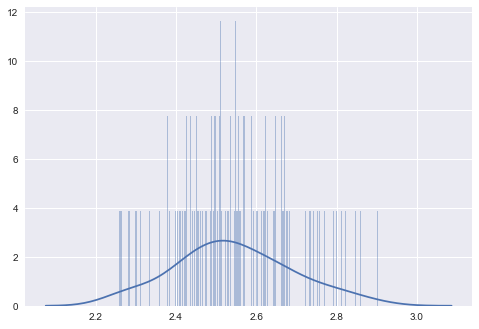

Distribution of rmse for G2
avg_value: 2.8150748694795205
max_value: 3.3294203879505018
min_value: 2.2122256849666018


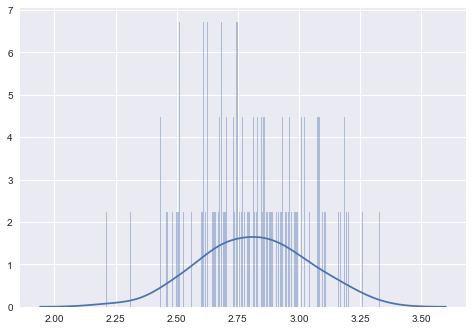

Distribution of rmse for G3
avg_value: 3.212213150315674
max_value: 3.8775754291023494
min_value: 2.6803997399064383


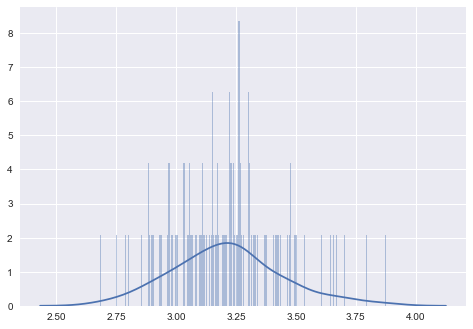

In [25]:
print("Distribution of rmse for G1")
print_distribution(rmse_G1)
print("Distribution of rmse for G2")
print_distribution(rmse_G2)
print("Distribution of rmse for G3")
print_distribution(rmse_G3)

### Final notes
- We have not questioned data availability and how this model would be used. Depending on when the model needs to be run,  we probably could use previous grades to predict the next. That means we could use G1 as a feature to predict G2, and G1 and G2 to predict G3. This would improve the performance by a lot, sice we saw in the exploratory analysis that G1, G2, and G3 are highly correlated. This can be a good additional improvement in case this assumtion applies
- We have not deep-dived into hyper parameter tunning. We could have played around with L1 and L2 regularizations, but given the small size of the data, we would have been tuning for a sample of the population (dev set) is not necesarily a good representation of the entire population
- We could have made a binary model for pass/not_pass, but found regression a bit more interesting
- Of course, many other algorythims could have been used. Additional exercise would be to test and compare them
- We could use bootstrapping because data was very small and iterations took very little time. Normally this is actually not needed because dev and test sets are big enaugh to be statistically representative of the whole population 